<a href="https://colab.research.google.com/github/divyanshuaggarwal/MyProjects/blob/master/Knowledge_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract Relations

In [1]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
22-year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


# Build a Knowledge Graph from Text Data


## Import Libraries

In [0]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

## Read Data

In [5]:
!wget https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/wiki_sentences_v2.csv

--2020-04-01 17:43:05--  https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/wiki_sentences_v2.csv
Resolving cdn.analyticsvidhya.com (cdn.analyticsvidhya.com)... 104.26.15.185, 104.26.14.185, 2606:4700:20::681a:fb9, ...
Connecting to cdn.analyticsvidhya.com (cdn.analyticsvidhya.com)|104.26.15.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 275069 (269K) [text/csv]
Saving to: ‘wiki_sentences_v2.csv’

wiki_sentences_v2.c 100%[===================>] 268.62K  --.-KB/s    in 0.001s  

2020-04-01 17:43:06 (175 MB/s) - ‘wiki_sentences_v2.csv’ saved [275069/275069]



In [6]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [7]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


## Entity Pairs Extraction


In [0]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [9]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [10]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:29<00:00, 147.88it/s]


In [11]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

## Relation / Predicate Extraction

In [0]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [13]:
get_relation("John completed the task")


'completed'

In [14]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]


100%|██████████| 4318/4318 [00:28<00:00, 152.87it/s]


In [15]:
pd.Series(relations).value_counts()[:50]


is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
became            31
has               31
have              31
become            29
released in       27
included          26
called            22
produced          22
had               20
made              20
considered        20
been              18
be                18
used              17
scheduled         17
directed by       16
stars             16
written by        15
produced by       14
hired             14
wrote             14
set               14
introduced in     13
went              13
received          13
wanted            12
began             11
began in          11
won               11
sold              10
features          10
gave              10
reported           9
shot in            9
produced in        9
opened             9
includes           9
gives              9
used in      

## Build a Knowledge Graph


In [0]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [0]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


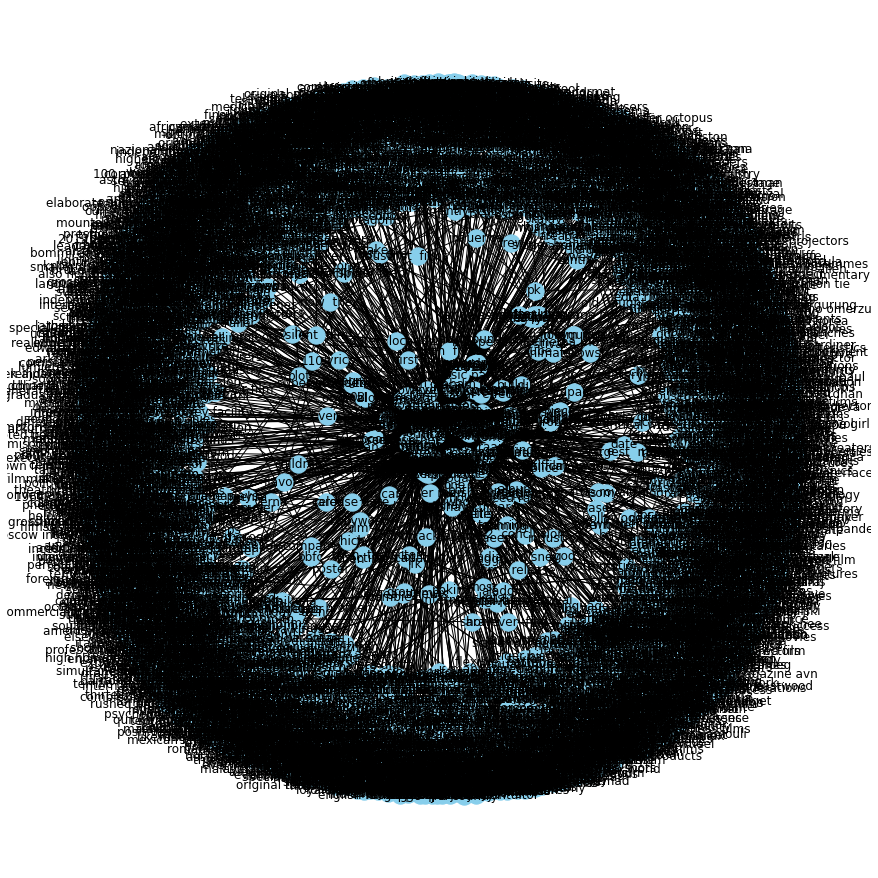

In [18]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

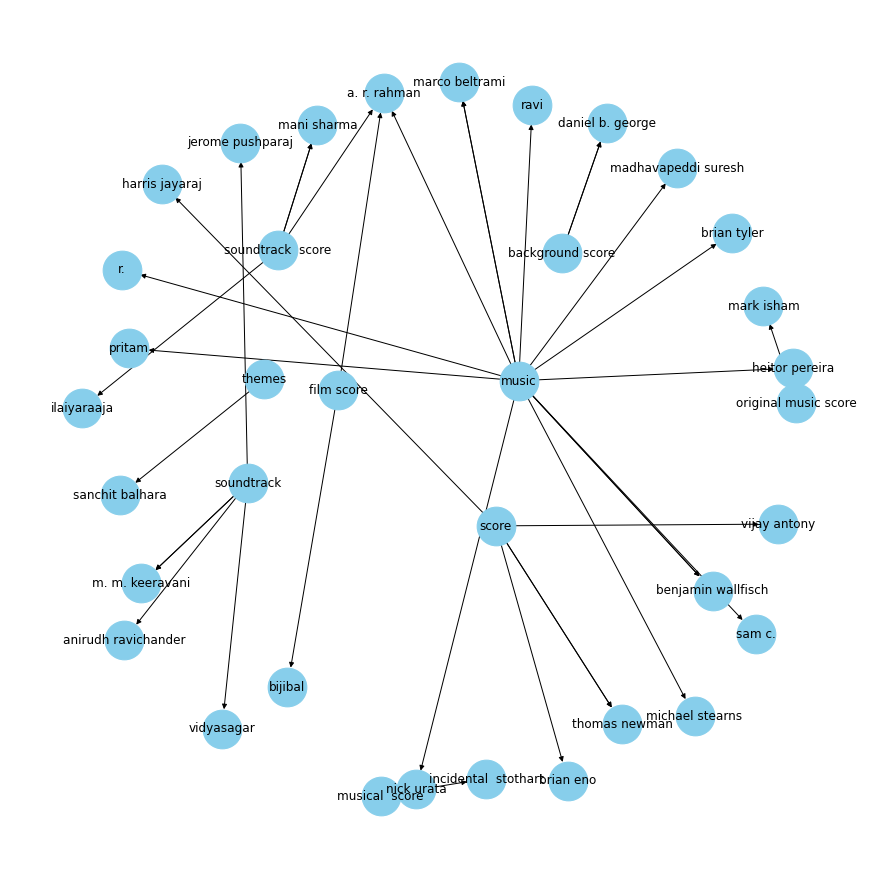

In [19]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

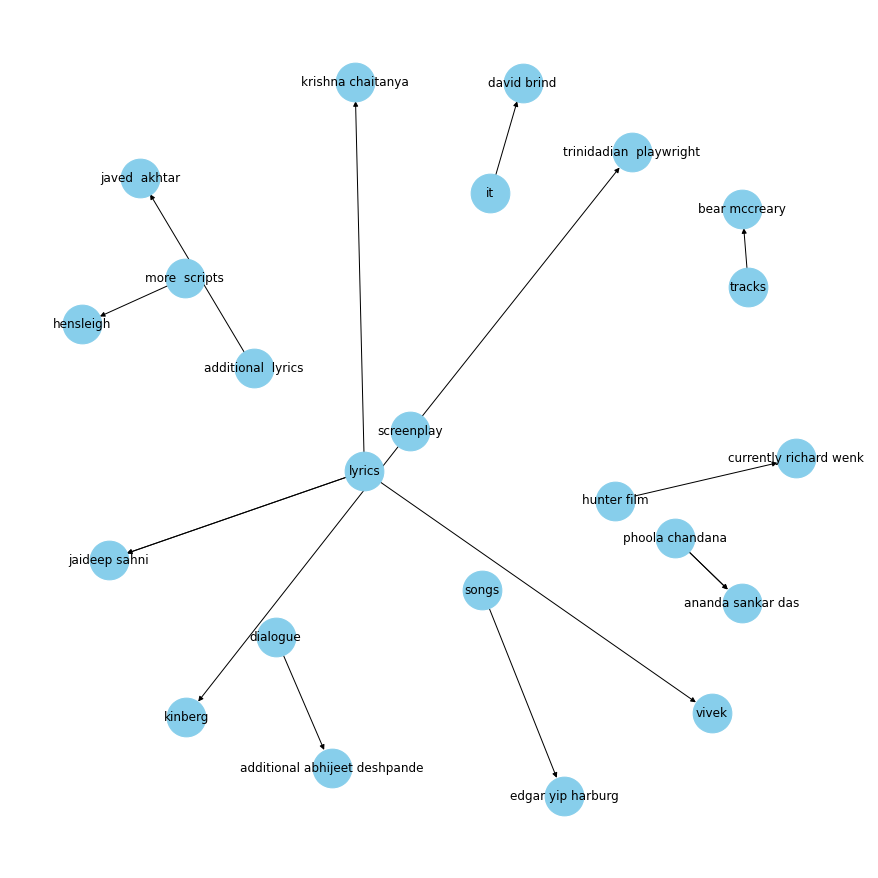

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

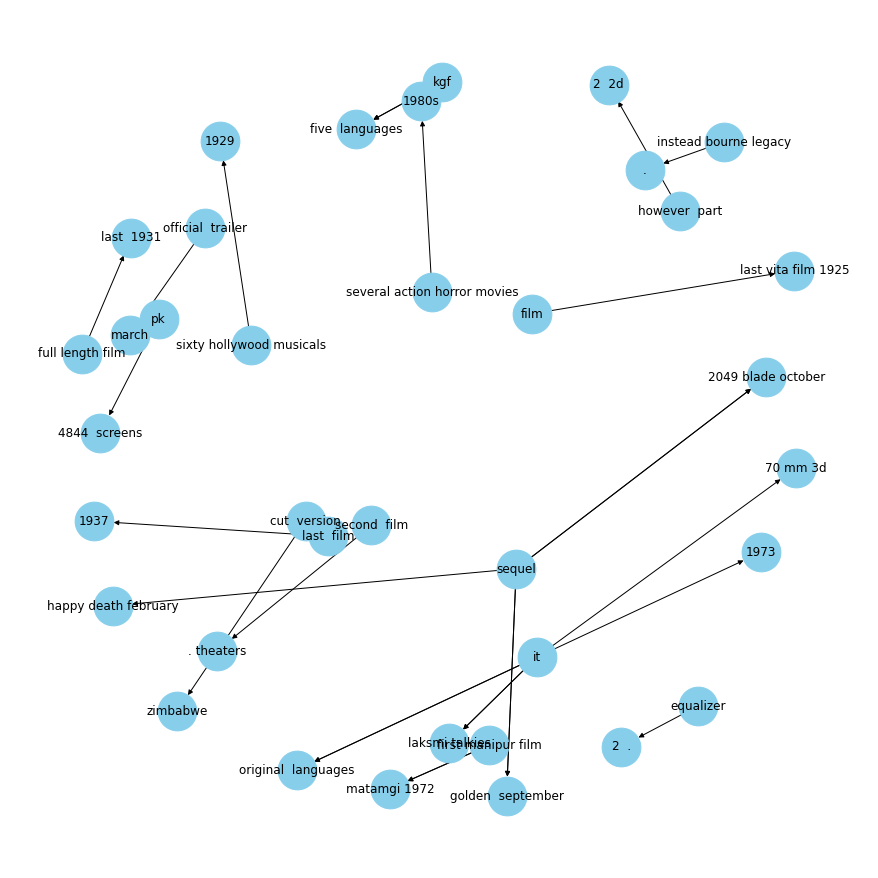

In [21]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()